# Machine Translation English-German Example Using SageMaker Seq2Seq

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Download dataset and preprocess](#Download-dataset-and-preprocess)
3. [Training the Machine Translation model](#Training-the-Machine-Translation-model)
4. [Inference](#Inference)

## Introduction

Welcome to our Machine Translation end-to-end example! In this demo, we will use a pre-trained English-German translation model and will deploy it for an internet-facing App. This notebook will take about 12-15 minutes to complete.

SageMaker Seq2Seq algorithm is built on top of [Sockeye](https://github.com/awslabs/sockeye), a sequence-to-sequence framework for Neural Machine Translation based on MXNet. SageMaker Seq2Seq implements state-of-the-art encoder-decoder architectures which can also be used for tasks like Abstractive Summarization in addition to Machine Translation.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Setup

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data. **This should be within the same region as the Notebook Instance, training, and hosting.**
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp in the cell below with a the appropriate full IAM role arn string(s).

In [1]:
# S3 bucket and prefix
bucket = '<your_s3_bucket_name_here>'
prefix = 'sagemaker/<your_s3_prefix_here>'  # E.g.'sagemaker/seq2seq/eng-german'

In [2]:
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [3]:
from time import gmtime, strftime
import time
import numpy as np
import os
import json

# For plotting attention matrix later on
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
def upload_to_s3(bucket, prefix, channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = prefix + "/" + channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

In [9]:
region_name = boto3.Session().region_name

In [10]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/seq2seq:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/seq2seq:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/seq2seq:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/seq2seq:latest'}
container = containers[region_name]
print('Using SageMaker Seq2Seq container: {} ({})'.format(container, region_name))

Using SageMaker Seq2Seq container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/seq2seq:latest (us-east-1)


## Inference

### Use a pretrained model

In [7]:
use_pretrained_model = True
model_name = "pretrained-en-de-model"
!curl https://s3-us-west-2.amazonaws.com/gsaur-seq2seq-data/seq2seq/eng-german/full-nb-translation-eng-german-p2-16x-2017-11-24-22-25-53/output/model.tar.gz > model.tar.gz
!curl https://s3-us-west-2.amazonaws.com/gsaur-seq2seq-data/seq2seq/eng-german/full-nb-translation-eng-german-p2-16x-2017-11-24-22-25-53/output/vocab.src.json > vocab.src.json
!curl https://s3-us-west-2.amazonaws.com/gsaur-seq2seq-data/seq2seq/eng-german/full-nb-translation-eng-german-p2-16x-2017-11-24-22-25-53/output/vocab.trg.json > vocab.trg.json
upload_to_s3(bucket, prefix, 'pretrained_model', 'model.tar.gz')
model_data = "s3://{}/{}/pretrained_model/model.tar.gz".format(bucket, prefix)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  312M  100  312M    0     0  14.1M      0  0:00:22  0:00:22 --:--:-- 15.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1066k  100 1066k    0     0  1066k      0  0:00:01  0:00:01 --:--:--  623k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1180k  100 1180k    0     0  1180k      0  0:00:01  0:00:01 --:--:--  652k


In [11]:
%%time

sage = boto3.client('sagemaker')

if not use_pretrained_model:
    info = sage.describe_training_job(TrainingJobName=job_name)
    model_name=job_name
    model_data = info['ModelArtifacts']['S3ModelArtifacts']

print(model_name)
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

pretrained-en-de-model
s3://pilho-sagemaker-ai-workshop/sagemaker/pilho-sagemaker-ai-workshop/pretrained_model/model.tar.gz
arn:aws:sagemaker:us-east-1:082256166551:model/pretrained-en-de-model
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 304 ms


### Create endpoint configuration
Use the model to create an endpoint configuration. The endpoint configuration also contains information about the type and number of EC2 instances to use when hosting the model.

Since SageMaker Seq2Seq is based on Neural Nets, we could use an ml.p2.xlarge (GPU) instance, but for this example we will use a free tier eligible ml.m4.xlarge.

In [12]:
from time import gmtime, strftime

endpoint_config_name = 'Seq2SeqEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Seq2SeqEndpointConfig-2018-03-24-08-35-50
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:082256166551:endpoint-config/seq2seqendpointconfig-2018-03-24-08-35-50


### Create endpoint
Lastly, we create the endpoint that serves up model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 10-15 minutes to complete.

In [13]:
%%time
import time

endpoint_name = 'Seq2SeqEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sage.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sage.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

# wait until the status has changed
sage.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sage.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

Seq2SeqEndpoint-2018-03-24-08-35-53
arn:aws:sagemaker:us-east-1:082256166551:endpoint/seq2seqendpoint-2018-03-24-08-35-53
Status: Creating
Endpoint creation ended with EndpointStatus = InService
CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 11min 3s


If you see the message,
> Endpoint creation ended with EndpointStatus = InService

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.  

We will finally create a runtime object from which we can invoke the endpoint.

In [15]:
runtime = boto3.client(service_name='runtime.sagemaker') 

# Perform Inference

### Using JSON format for inference (Suggested for a single or small number of data instances)

#### Note that you don't have to convert string to text using the vocabulary mapping for inference using JSON mode

In [16]:
sentences = ["you are so good !",
             "can you drive a car ?",
             "i want to watch a movie ."
            ]

payload = {"instances" : []}
for sent in sentences:
    payload["instances"].append({"data" : sent})

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)
print(response)

{'predictions': [{'target': 'Sie sind so gut !'}, {'target': 'können Sie ein Auto fahren ?'}, {'target': 'ich will einen Film besuchen .'}]}


### Retrieving the Attention Matrix

Passing `"attention_matrix":"true"` in `configuration` of the data instance will return the attention matrix.

In [17]:
sentence = 'can you drive a car ?'

payload = {"instances" : [{
                            "data" : sentence,
                            "configuration" : {"attention_matrix":"true"}
                          }
                         ]}

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)['predictions'][0]

source = sentence
target = response["target"]
attention_matrix = np.array(response["matrix"])

print("Source: %s \nTarget: %s" % (source, target))

Source: can you drive a car ? 
Target: können Sie ein Auto fahren ?


In [18]:
# Define a function for plotting the attentioan matrix
def plot_matrix(attention_matrix, target, source):
    source_tokens = source.split()
    target_tokens = target.split()
    assert attention_matrix.shape[0] == len(target_tokens)
    plt.imshow(attention_matrix.transpose(), interpolation="nearest", cmap="Greys")
    plt.xlabel("target")
    plt.ylabel("source")
    plt.gca().set_xticks([i for i in range(0, len(target_tokens))])
    plt.gca().set_yticks([i for i in range(0, len(source_tokens))])
    plt.gca().set_xticklabels(target_tokens)
    plt.gca().set_yticklabels(source_tokens)
    plt.tight_layout()

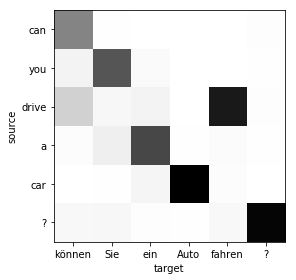

In [19]:
plot_matrix(attention_matrix, target, source)

### Using Protobuf format for inference (Suggested for efficient bulk inference)

Reading the vocabulary mappings as this mode of inference accepts list of integers and returns list of integers.

In [20]:
import io
import tempfile
from record_pb2 import Record
from create_vocab_proto import vocab_from_json, reverse_vocab, write_recordio, list_to_record_bytes, read_next

source = vocab_from_json("vocab.src.json")
target = vocab_from_json("vocab.trg.json")

source_rev = reverse_vocab(source)
target_rev = reverse_vocab(target)

In [21]:
sentences = ["this is so cool",
            "i am having dinner .",
            "i am sitting in an aeroplane .",
            "come let us go for a long drive ."]

Converting the string to integers, followed by protobuf encoding:

In [22]:
# Convert strings to integers using source vocab mapping. Out-of-vocabulary strings are mapped to 1 - the mapping for <unk>
sentences = [[source.get(token, 1) for token in sentence.split()] for sentence in sentences]
f = io.BytesIO()
for sentence in sentences:
    record = list_to_record_bytes(sentence, [])
    write_recordio(f, record)

In [23]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-recordio-protobuf', 
                                   Body=f.getvalue())

response = response["Body"].read()

Now, parse the protobuf response and convert list of integers back to strings

In [25]:
def _parse_proto_response(received_bytes):
    output_file = tempfile.NamedTemporaryFile()
    output_file.write(received_bytes)
    output_file.flush()
    target_sentences = []
    with open(output_file.name, 'rb') as datum:
        next_record = True
        while next_record:
            next_record = read_next(datum)
            if next_record:
                rec = Record()
                rec.ParseFromString(next_record)
                target = list(rec.features["target"].int32_tensor.values)
                target_sentences.append(target)
            else:
                break
    return target_sentences

In [26]:
targets = _parse_proto_response(response)
resp = [" ".join([target_rev.get(token, "<unk>") for token in sentence]) for
                               sentence in targets]
print(resp)

['das ist so cool .', 'ich bin mit dem Abendessen <unk> .', 'ich <unk> Sie in einem Flugzeug .', 'lassen Sie uns eine lange Fahrt gehen .']


# Stop / Close the Endpoint (Optional)

Finally, we should delete the endpoint before we close the notebook.

In [ ]:
#sage.delete_endpoint(EndpointName=endpoint_name)